In [6]:
import torch
import torch_geometric
from torch_geometric.datasets import TUDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

### Import Dataset

In [4]:
dataset = TUDataset(root='datasets/', name='IMDB-BINARY')

Extracting datasets\IMDB-BINARY\IMDB-BINARY.zip
Processing...
Done!


### Preprocessing

#### Make dataset compatible with networkx, for Louvain algorithm

In [5]:
# edge transform
def edgeToTuple(edge):
    st = []
    for _, (s, d) in enumerate(zip(edge[0], edge[1])):
        st.append((s.item(), d.item()))
    return st

In [15]:
netx_graphs = []
for graph in dataset:
    G = nx.Graph(edgeToTuple(graph.edge_index))
    netx_graphs.append(G)

Sample


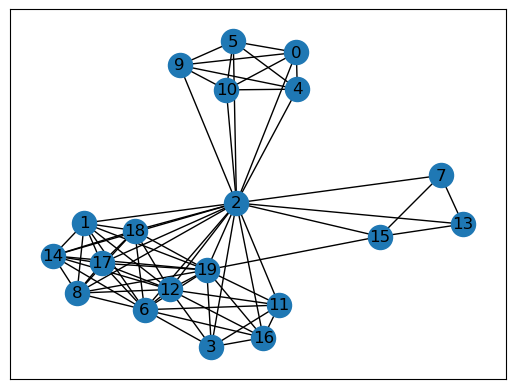

In [28]:
print('Sample')
nx.draw_networkx(netx_graphs[0])

#### Louvain Algorithm - Graph community detection

In [46]:
def makeCommunity(G):
    communities = nx.community.louvain_communities(G, seed=42)
    sub = []
    for c in communities:
        w = G.subgraph(c)
        # print(w.edges)
        sub.append(w.edges)
        # nx.draw_networkx(w, nx.spring_layout(G, seed=6))
    return sub

In [143]:
graph_subs = []
for G in netx_graphs:
    communities = makeCommunity(G)
    edge_from = []
    edge_to = []
    for c in communities:
        for edge in c:
            edge_from.append(edge[0])
            edge_to.append(edge[1])
    graph_subs.append(torch.tensor([edge_from,edge_to]))

In [144]:
graph_oris = []
for g in dataset:
    # print(g.edge_index[1])
    graph_oris.append([g.edge_index[0], g.edge_index[1]])

#### Data Description after preprocessing

1. List of edges, shows relation of pair of nodes ```from``` and ```to```. <br>
```graph_subs (list[tensor()])``` <br>
```graph_oris (list[tensor()])``` 

In [145]:
graph_subs[0][0]

tensor([ 0,  0,  0,  0,  0,  2,  2,  2,  2,  4,  4,  4,  5,  5,  9,  1,  1,  1,
         1,  1,  1,  1,  6,  6,  6,  6,  6,  6,  8,  8,  8,  8,  8, 12, 12, 12,
        12, 14, 14, 14, 17, 17, 18, 16, 16,  3, 15, 15, 13])

In [146]:
graphs = []
for _, (ori, sub, target) in enumerate(zip(graph_oris, graph_subs, dataset)):
    # print(target.y)
    graphs.append([ori, sub, target.y])

```graphs[i]``` shows object of one graph <br>
```graphs[i][j]``` features of graph, ```j=0```: original edge index, ```j=1```: louvain subgraph, ```j=2```: graph target class

In [148]:
graphs[0]

[[tensor([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
           3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,
           6,  6,  6,  6,  6,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,
           9,  9,  9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12,
          12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14,
          15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17,
          18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
          19, 19]),
  tensor([ 2,  4,  5,  9, 10,  2,  6,  8, 12, 14, 17, 18, 19,  0,  1,  3,  4,  5,
           6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2,  6, 11, 12,
          16, 19,  0,  2,  5,  9, 10,  0,  2,  4,  9, 10,  1,  2,  3,  8, 11, 12,
          14, 16, 17, 18, 19,  2, 13, 15,  1,  2,  6, 12, 14, 17, 18, 19,  0, 